In [1]:
%matplotlib inline

In [2]:
import os, sys

In [3]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot
from datetime import timedelta

In [4]:
import functools

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller


class SadfTest:
    """ Suppremum-Augmented Dickey Fuller Test
    TODO: Implment quantile and conditional SADF test features described in de Prado.
    Ref: de Prado Section 17.3.2
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
    """
    def __init__(self, ticks_required, minimum_sample_length_perc=0.5):
        self.ticks_required = ticks_required
        # out name should uniquely identify the feature with all its args
        self.output_column_names = ['{0}_sadf_test'.format(self.ticks_required)]
        #for ticks in ticks_required:
         #   self.output_column_names.append('{0}_sadf_test'.format(ticks))

        self.minimum_sample_length = int(ticks_required * minimum_sample_length_perc)
    
        assert self.minimum_sample_length <= ticks_required
            
        # TODO: Investigate how the number of lags effects the result
        self.lag_order = 1
        self.minimum_sample_length = int(ticks_required
                                         * minimum_sample_length_perc)
        self.minimum_sample_length = max(self.minimum_sample_length,
                                         self.lag_order + 1)


        def compute_sdaf_stat(x):
            def adf(s_idx):
                # TODO: Investigate the effect of adding time trend to the specification.
                return adfuller(x[s_idx:], maxlag=self.lag_order,
                                autolag=None)[0]
            start_points = range(0, len(x) - self.minimum_sample_length)
            # TODO: This can perhaps be sped up using Pandas expanding windows and apply function.
            return functools.reduce(max, map(adf, start_points))

        buffer = pd.Series(data=np.empty(self.ticks_required))

        def compute_sdaf_stat_vec(x):
            """
            This vectorized version is not faster.
            """
            def adf(y):
                return adfuller(y[::-1],  maxlag=self.lag_order,
                                autolag=None)[0]

            buffer.iloc[:] = x[::-1]
            expanding = buffer.expanding(min_periods=self.minimum_sample_length)
            return expanding.apply(adf).max()

        self.compute_sdaf_stat = compute_sdaf_stat
        # self.compute_sdaf_stat = compute_sdaf_stat_vec


    def generate_bulk(self, reg_ticks: pd.DataFrame):
        log_prices = np.log(reg_ticks['close'])
        rolling = log_prices.rolling(self.ticks_required,
                                     min_periods=self.ticks_required)

        data = (
            rolling.apply(self.compute_sdaf_stat, raw=True)
            .values).astype(np.float)

        return pd.DataFrame(index=reg_ticks.index,
                            data=data,
                            columns=self.output_column_names)


In [5]:
class StructuralBreakFeatures:
    DEFAULT_FEATURES_TO_CALCULATE = []
    DROP_COLUMNS = ['open', 'high', 'low']

    def __init__(self,
                 features_to_calculate=None,
                 interval_size: timedelta=timedelta(days=1),
                 drop_columns=None):
        if features_to_calculate is None:
            features_to_calculate = self.DEFAULT_FEATURES_TO_CALCULATE

        if drop_columns is None:
            drop_columns = self.DROP_COLUMNS

        # Create feature generator and compute features
        self.interval_type = 'time'
        self.interval_size = interval_size
        self.features_to_calculate = features_to_calculate
        self.drop_columns = drop_columns

    def get_feature_data(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = SadfTest(self.features_to_calculate)
        data_df_enriched = data_df.join(feature_generator.generate_bulk(data_df))
#         data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

    def get_feature_data_log_volume(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = SadfTest(self.features_to_calculate)
        data_df = data_df[data_df['close'] != 0]
        data_df = data_df[data_df['volume'] != 0]
        data_df_enriched = data_df.join(feature_generator.generate_bulk_log_volume(data_df))
#         data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

In [6]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='USDT_BTC', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query,verify=False)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [7]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=0, end=9999999999, period=86400)
#no option to pass in 3600 sec candles
#df = df[df.index % 4 == 0]
#df['ds'] = pd.to_datetime(df['date'], unit='s')
#df['y'] = df['volume']
#df['logVolume'] = df['volume'].apply(np.log)

/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [8]:
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778
1,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479
2,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000
3,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608
4,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062


In [9]:
df['time'] = pd.to_datetime(df['date'], unit='s')
df.index = df['time']
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time
time,,,,,,,,,
2015-02-19,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778,2015-02-19
2015-02-20,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479,2015-02-20
2015-02-21,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000,2015-02-21
2015-02-22,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608,2015-02-22
2015-02-23,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062,2015-02-23


In [10]:
df_prices = df[['close', 'high', 'low', 'open', 'weightedAverage']]
df_volume = (df[['quoteVolume', 'volume']] + 0.001)
log_df = np.log(pd.concat([df_prices, df_volume], axis=1))
log_df.head()

,close,high,low,open,weightedAverage,quoteVolume,volume
time,,,,,,,
2015-02-19,5.497168,-1.108663,5.416100,-1.108663,5.479087,-1.639292,3.834652
2015-02-20,5.481680,5.501258,5.481680,5.481681,5.491284,-1.463481,4.023491
2015-02-21,5.501258,5.501258,5.501258,5.501258,5.501258,-2.795394,2.689427
2015-02-22,5.459586,5.517453,5.459586,5.501258,5.478690,-0.616084,4.860760
2015-02-23,5.459586,5.459590,5.459586,5.459586,5.459586,-0.886912,4.570253


In [11]:
df_daily = df#.resample('D').mean()
df_log_daily = log_df#.resample('D').mean()
df_daily['time'] = pd.to_datetime(df_daily.index)
df_log_daily['time'] = pd.to_datetime(df_log_daily.index)

In [12]:
df_daily.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,time
time,,,,,,,,,
2015-02-19,244.00,1424304000,0.330,225.00,0.330000,0.193117,46.276313,239.627778,2015-02-19
2015-02-20,240.25,1424390400,245.000,240.25,240.250118,0.230429,55.894897,242.568479,2015-02-20
2015-02-21,245.00,1424476800,245.000,245.00,245.000000,0.060091,14.722239,245.000000,2015-02-21
2015-02-22,235.00,1424563200,249.000,235.00,245.000000,0.539055,129.121248,239.532608,2015-02-22
2015-02-23,235.00,1424649600,235.001,235.00,235.000002,0.410926,96.567562,235.000062,2015-02-23


In [38]:
features = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [40]:
sadf_enriched1024 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  \
time                                                                
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11   
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12   

            1024_sadf_test  
time                        
2018-10-11       -0.857446  
2018-10-12       -0.856193  


In [42]:
sadf_enriched1024.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,1024_sadf_test
count,1332.000000,1.332000e+03,1332.000000,1332.000000,1332.000000,1332.000000,1.332000e+03,1332.000000,309.000000
mean,3071.660906,1.481803e+09,3177.227751,2937.889232,3067.238059,3285.008457,1.587597e+07,3058.084323,0.207271
std,3844.032820,3.323459e+07,4010.276497,3633.347015,3844.477367,5861.017373,3.320025e+07,3819.227518,1.070736
min,178.719313,1.424304e+09,0.330000,99.000000,0.330000,0.000000,0.000000e+00,207.450144,-0.857446
25%,409.960000,1.453054e+09,419.997392,399.887500,409.397250,35.909858,1.379017e+04,410.579737,-0.588936
50%,780.455800,1.481803e+09,787.804666,771.182148,778.613189,715.440567,8.495166e+05,779.182454,-0.104193
75%,6241.250001,1.510553e+09,6379.096390,6032.564958,6226.091999,4202.227243,1.736765e+07,6239.144501,0.589458
max,19223.000000,1.539302e+09,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652,3.526838


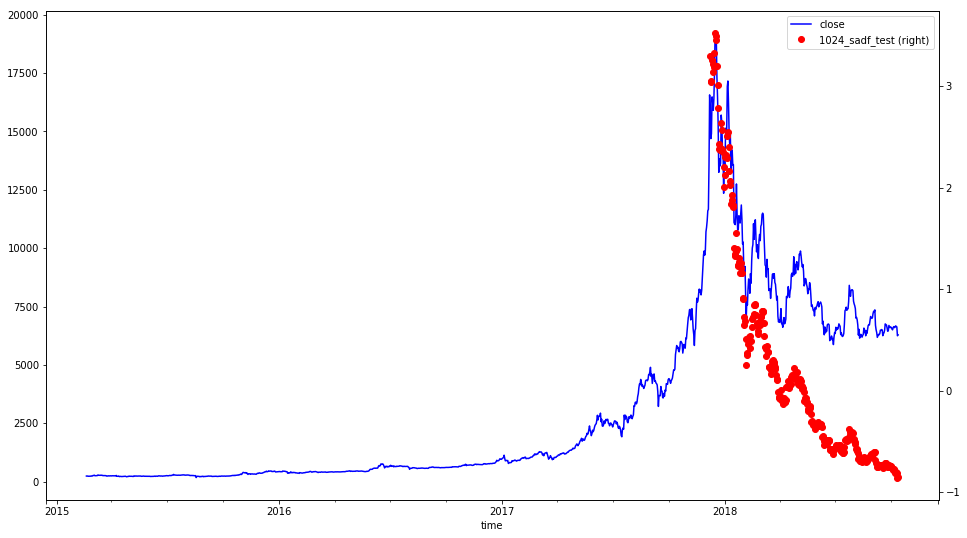

In [44]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched1024['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched1024['1024_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [31]:
features = [2, 4, 8, 16, 32, 64, 128, 256, 512]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [32]:
sadf_enriched = sadf_features.get_feature_data(df_daily)
print(sadf_enriched.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  \
time                                                                
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11   
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12   

            512_sadf_test  
time                       
2018-10-11      -1.379083  
2018-10-12      -1.387714  


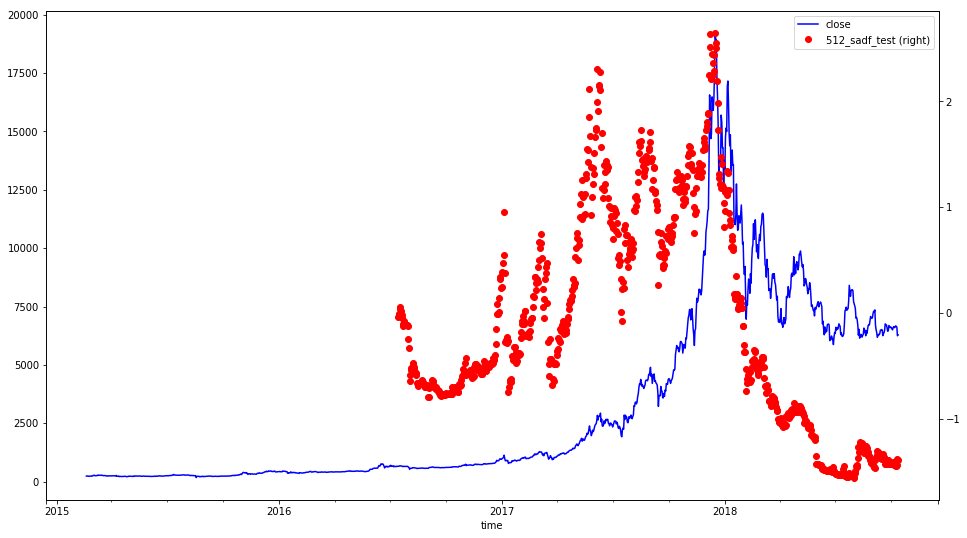

In [37]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['512_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [45]:
features = [2, 4, 8, 16, 32, 64, 128, 256]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [46]:
sadf_enriched256 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched256.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  \
time                                                                
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11   
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12   

            256_sadf_test  
time                       
2018-10-11      -1.419959  
2018-10-12      -1.428433  


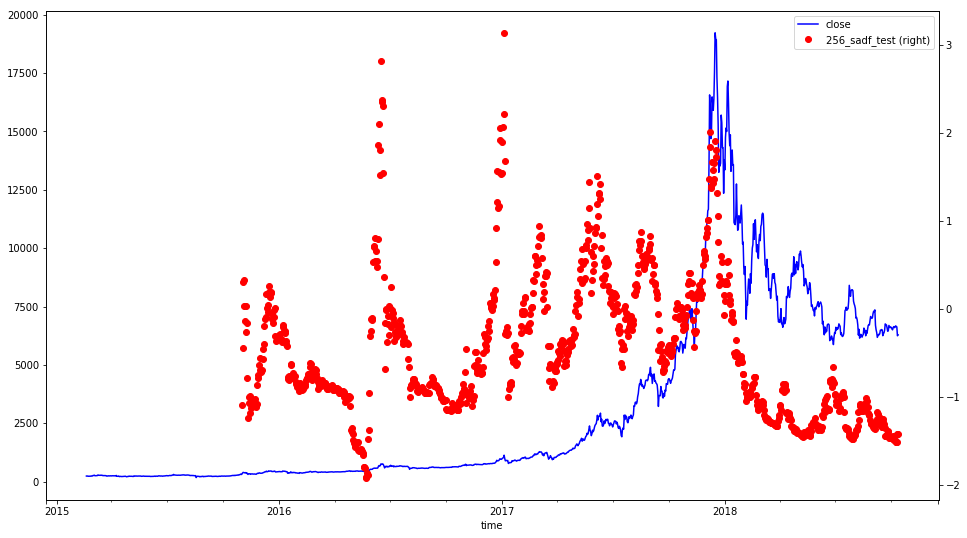

In [47]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched256['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched256['256_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [48]:
features = [2, 4, 8, 16, 32, 64, 128]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [49]:
sadf_enriched128 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched128.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  \
time                                                                
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11   
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12   

            128_sadf_test  
time                       
2018-10-11      -1.568069  
2018-10-12      -1.597082  


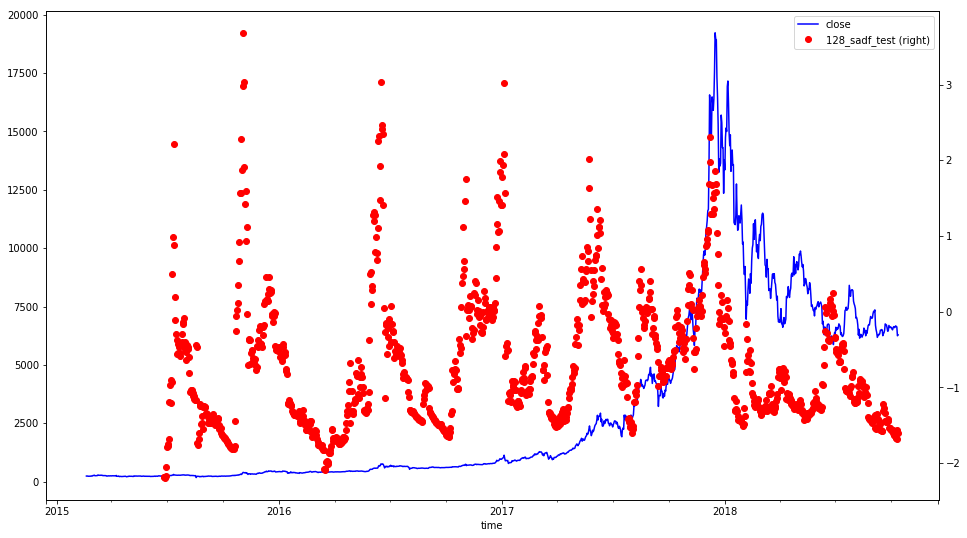

In [50]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched128['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched128['128_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [51]:
features = [2, 4, 8, 16, 32, 64]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [52]:
sadf_enriched64 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched64.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  \
time                                                                
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11   
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12   

            64_sadf_test  
time                      
2018-10-11     -2.030327  
2018-10-12     -2.070325  


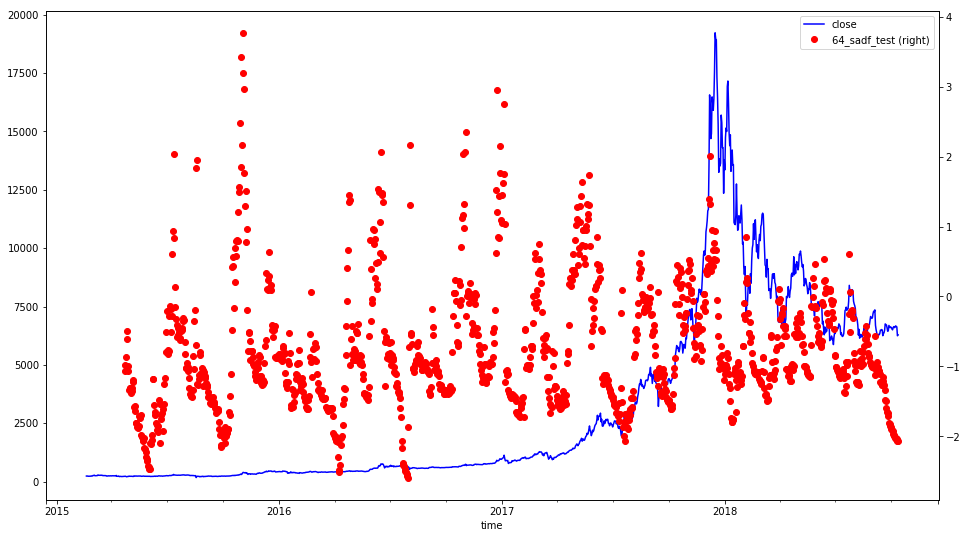

In [53]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched64['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched64['64_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [54]:
features = [2, 4, 8, 16, 32]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [55]:
sadf_enriched32 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched32.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  \
time                                                                
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11   
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12   

            32_sadf_test  
time                      
2018-10-11     -2.740925  
2018-10-12     -1.572307  


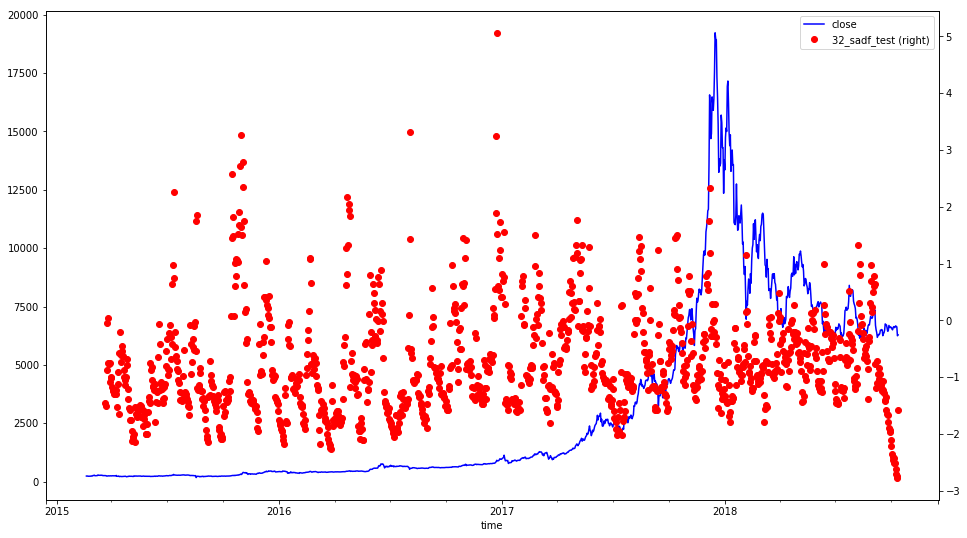

In [56]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched32['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched32['32_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [57]:
features = [2, 4, 8, 16]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [58]:
sadf_enriched16 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched16.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  \
time                                                                
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11   
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12   

            16_sadf_test  
time                      
2018-10-11     -0.531452  
2018-10-12     -1.047543  


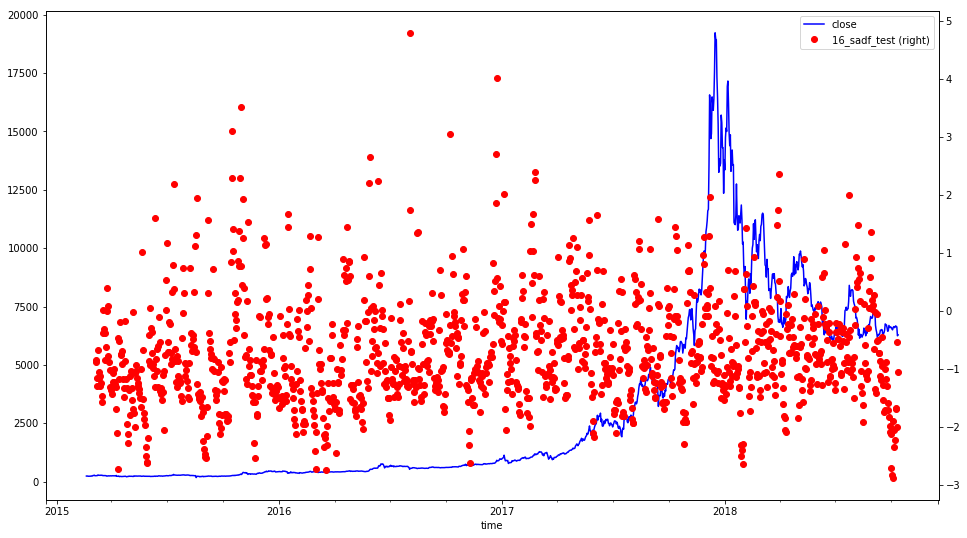

In [59]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched16['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched16['16_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [60]:
features = [2, 4, 8]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [61]:
sadf_enriched8 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched8.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  8_sadf_test  
time                                                                            
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11          0.0  
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12          0.0  


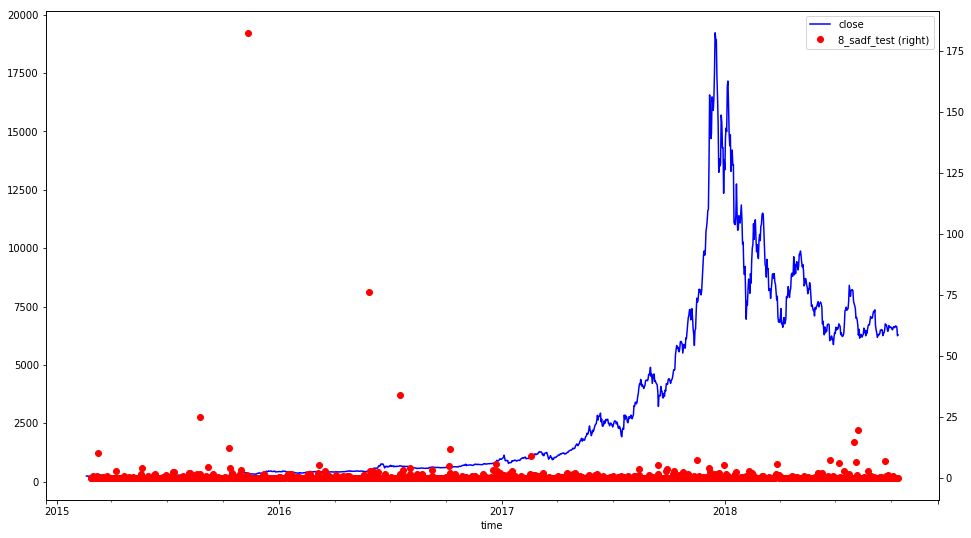

In [62]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched8['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched8['8_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [63]:
features = [2, 4]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [64]:
sadf_enriched4 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched4.tail(2))

                  close        date         high          low    open  \
time                                                                    
2018-10-11  6250.284490  1539216000  6632.776373  6202.349831  6630.2   
2018-10-12  6287.756187  1539302400  6288.000000  6200.000000  6253.0   

            quoteVolume        volume  weightedAverage       time  4_sadf_test  
time                                                                            
2018-10-11  1927.565051  1.222207e+07      6340.678237 2018-10-11          0.0  
2018-10-12   163.874400  1.022275e+06      6238.160691 2018-10-12         -0.0  


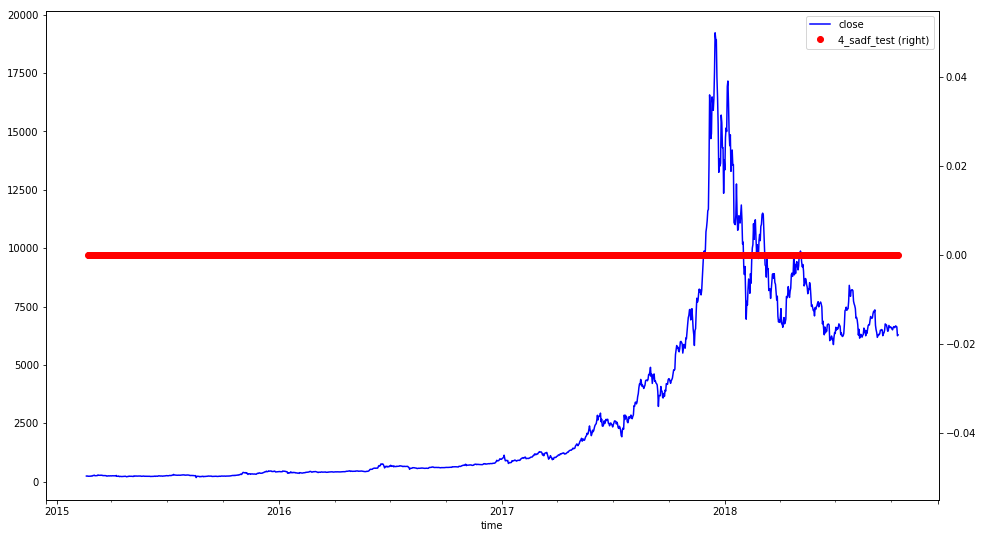

In [65]:
#for feature in features:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched4['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched4['4_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)